In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !mkdir dataset
# !mkdir dataset
# !unzip drive/MyDrive/mapaton2022/TrainData.zip
# !unzip drive/MyDrive/mapaton2022/ValidData.zip
# !unzip drive/MyDrive/mapaton2022/TestData.zip
!cp drive/MyDrive/mapaton2022/dataset/train.txt train.txt
!cp drive/MyDrive/mapaton2022/dataset/valid.txt valid.txt
!cp drive/MyDrive/mapaton2022/dataset/test.txt test.txt
!cp drive/MyDrive/mapaton2022/model/Networks.py Networks.py
# !cp exp/batch4500_F1_7434.pth drive/MyDrive/mapaton2022/exp/batch4500_F1_7434.pth

## Leer dataset

In [1]:
import requests
import re
import os
import h5py

In [2]:
path_img = r'TrainData/img/image_5.h5'
mask_img = r'TrainData/mask/mask_5.h5'

with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

In [3]:
image.shape

(128, 128, 14)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


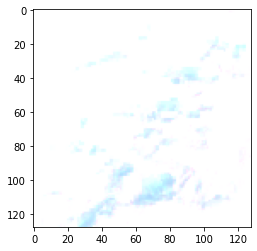

In [4]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

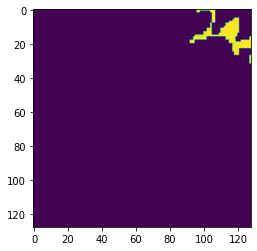

In [5]:
plt.imshow(label)

## Dataloader

In [ ]:
import numpy as np
import torch
from torch.utils import data
from torch.utils.data import DataLoader
import h5py

class LandslideDataSet(data.Dataset):
    def __init__(self, data_dir, list_path, max_iters=None, set='labeled'):
        self.list_path = list_path
        self.mean = [-0.4914, -0.3074, -0.1277, -0.0625, 0.0439, 0.0803, 0.0644, 0.0802, 0.3000, 0.4082, 0.0823, 0.0516, 0.3338, 0.7819]
        self.std = [0.9325, 0.8775, 0.8860, 0.8869, 0.8857, 0.8418, 0.8354, 0.8491, 0.9061, 1.6072, 0.8848, 0.9232, 0.9018, 1.2913]
        self.set = set
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        
        if not max_iters==None:
            n_repeat = int(np.ceil(max_iters / len(self.img_ids)))
            self.img_ids = self.img_ids * n_repeat + self.img_ids[:max_iters-n_repeat*len(self.img_ids)]
        
        self.files = []
        
        if set=='labeled':
            for name in self.img_ids:
                img_file = data_dir + name
                label_file = data_dir + name.replace('img','mask').replace('image','mask')
                self.files.append({
                    'img': img_file,
                    'label': label_file,
                    'name': name
                })
        elif set=='unlabeled':
            for name in self.img_ids:
                img_file = data_dir + name
                self.files.append({
                    'img': img_file,
                    'name': name
                })
            
    def __len__(self):
        return len(self.files)


    def __getitem__(self, index):
        datafiles = self.files[index]
        
        if self.set=='labeled':
            with h5py.File(datafiles['img'], 'r') as hf:
                image = hf['img'][:]
            with h5py.File(datafiles['label'], 'r') as hf:
                label = hf['mask'][:]
            name = datafiles['name']
                
            image = np.asarray(image, np.float32)
            label = np.asarray(label, np.float32)
            image = image.transpose((-1, 0, 1))
            size = image.shape

            for i in range(len(self.mean)):
                image[i,:,:] -= self.mean[i]
                image[i,:,:] /= self.std[i]

            return image.copy(), label.copy(), np.array(size), name

        else:
            with h5py.File(datafiles['img'], 'r') as hf:
                image = hf['img'][:]
            name = datafiles['name']
                
            image = np.asarray(image, np.float32)
            image = image.transpose((-1, 0, 1))
            size = image.shape

            for i in range(len(self.mean)):
                image[i,:,:] -= self.mean[i]
                image[i,:,:] /= self.std[i]

            return image.copy(), np.array(size), name

In [ ]:
train_dataset = LandslideDataSet(data_dir=r'', list_path=r'train.txt') # data_dir='/scratch/Land4Sense_Competition/', 
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, pin_memory=True)

In [ ]:
channels_sum,channel_squared_sum = 0,0
num_batches = len(train_loader)
for data,_,_,_ in train_loader:
    channels_sum += torch.mean(data,dim=[0,2,3])   
    channel_squared_sum += torch.mean(data**2,dim=[0,2,3])       

mean = channels_sum/num_batches
std = (channel_squared_sum/num_batches - mean**2)**0.5
print(mean,std) 

tensor([1.5197, 1.4018, 1.2210, 1.1525, 1.1052, 1.1432, 1.1628, 1.1383, 0.9601,
        0.4762, 1.0931, 1.0674, 1.0172, 0.6719]) tensor([0.1512, 0.2515, 0.3594, 0.6454, 0.5195, 0.5304, 0.5567, 0.5828, 0.5665,
        0.4253, 0.6016, 0.7179, 0.7522, 0.8307])


### Modelo

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class unet(nn.Module):
    def __init__(self, n_classes, n_channels=14, bilinear=True):
        super(unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [ ]:
import numpy as np

def eval_image(predict,label,num_classes):
    index = np.where((label>=0) & (label<num_classes))
    predict = predict[index]
    label = label[index] 
    
    TP = np.zeros((num_classes, 1))
    FP = np.zeros((num_classes, 1))
    TN = np.zeros((num_classes, 1))
    FN = np.zeros((num_classes, 1))
    
    for i in range(0,num_classes):
        TP[i] = np.sum(label[np.where(predict==i)]==i)
        FP[i] = np.sum(label[np.where(predict==i)]!=i)
        TN[i] = np.sum(label[np.where(predict!=i)]!=i)
        FN[i] = np.sum(label[np.where(predict!=i)]==i)        
    
    return TP,FP,TN,FN,len(label)

### Train

In [ ]:
import numpy as np
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.backends.cudnn as cudnn
import importlib

name_classes = ['Non-Landslide','Landslide']
epsilon = 1e-14

def importName(modulename, name):
    """ Import a named object from a module in the context of this function.
    """
    try:
        module = __import__(modulename, globals(), locals(  ), [name])
    except ImportError:
        return None
    return vars(module)[name]

def main():
    data_dir = r''
    model_module = 'Networks'
    model_name = 'unet'
    train_list = 'train.txt'
    test_list = 'valid.txt'
    input_size = '128,128'
    num_classes = 2
    batch_size = 32
    num_workers = 4
    learning_rate = 1e-3
    num_steps = 5000
    num_steps_stop = 5000
    weight_decay = 5e-4
    gpu_id = 0
    snapshot_dir = 'exp/'

    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    snapshot_dir = snapshot_dir
    if os.path.exists(snapshot_dir)==False:
        os.makedirs(snapshot_dir)

    w, h = map(int, input_size.split(','))
    input_size = (w, h)

    cudnn.enabled = True
    cudnn.benchmark = True
    
    # Create network   
    model_import = importName(model_module, model_name)
    model = model_import(n_classes=num_classes)
    model.train()
    model = model.cuda()

    src_loader = data.DataLoader(
                    LandslideDataSet(data_dir, train_list, max_iters=num_steps_stop*batch_size,set='labeled'),
                    batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)


    test_loader = data.DataLoader(
                    LandslideDataSet(data_dir, train_list, set='labeled'),
                    batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True)


    optimizer = optim.Adam(model.parameters(),
                        lr=learning_rate, weight_decay=weight_decay)
    
    interp = nn.Upsample(size=(input_size[1], input_size[0]), mode='bilinear')
    
    hist = np.zeros((num_steps_stop,3))
    F1_best = 0.5    
    cross_entropy_loss = nn.CrossEntropyLoss(ignore_index=255)

    for batch_id, src_data in enumerate(src_loader):
        if batch_id==num_steps_stop:
            break
        tem_time = time.time()
        model.train()
        optimizer.zero_grad()
        
        images, labels, _, _ = src_data
        images = images.cuda()      
        pred = model(images)   
        
        pred_interp = interp(pred)
              
        # CE Loss
        labels = labels.cuda().long()
        cross_entropy_loss_value = cross_entropy_loss(pred_interp, labels)
        _, predict_labels = torch.max(pred_interp, 1)
        predict_labels = predict_labels.detach().cpu().numpy()
        labels = labels.cpu().numpy()
        batch_oa = np.sum(predict_labels==labels)*1./len(labels.reshape(-1))

            
        hist[batch_id,0] = cross_entropy_loss_value.item()
        hist[batch_id,1] = batch_oa
        
        cross_entropy_loss_value.backward()
        optimizer.step()

        hist[batch_id,-1] = time.time() - tem_time

        if (batch_id+1) % 10 == 0: 
            print('Iter %d/%d Time: %.2f Batch_OA = %.1f cross_entropy_loss = %.3f'%(batch_id+1,num_steps,10*np.mean(hist[batch_id-9:batch_id+1,-1]),np.mean(hist[batch_id-9:batch_id+1,1])*100,np.mean(hist[batch_id-9:batch_id+1,0])))
           
        # evaluation per 500 iterations
        if (batch_id+1) % 500 == 0:            
            print('Testing..........')
            model.eval()
            TP_all = np.zeros((num_classes, 1))
            FP_all = np.zeros((num_classes, 1))
            TN_all = np.zeros((num_classes, 1))
            FN_all = np.zeros((num_classes, 1))
            n_valid_sample_all = 0
            F1 = np.zeros((num_classes, 1))
        
            for _, batch in enumerate(test_loader):  
                image, label,_, name = batch
                label = label.squeeze().numpy()
                image = image.float().cuda()
                
                with torch.no_grad():
                    pred = model(image)

                _,pred = torch.max(interp(nn.functional.softmax(pred,dim=1)).detach(), 1)
                pred = pred.squeeze().data.cpu().numpy()                       
                               
                TP,FP,TN,FN,n_valid_sample = eval_image(pred.reshape(-1),label.reshape(-1),num_classes)
                TP_all += TP
                FP_all += FP
                TN_all += TN
                FN_all += FN
                n_valid_sample_all += n_valid_sample

            OA = np.sum(TP_all)*1.0 / n_valid_sample_all
            for i in range(num_classes):
                P = TP_all[i]*1.0 / (TP_all[i] + FP_all[i] + epsilon)
                R = TP_all[i]*1.0 / (TP_all[i] + FN_all[i] + epsilon)
                F1[i] = 2.0*P*R / (P + R + epsilon)
                if i==1:
                    print('===>' + name_classes[i] + ' Precision: %.2f'%(P * 100))
                    print('===>' + name_classes[i] + ' Recall: %.2f'%(R * 100))                
                    print('===>' + name_classes[i] + ' F1: %.2f'%(F1[i] * 100))

            mF1 = np.mean(F1)            
            print('===> mean F1: %.2f OA: %.2f'%(mF1*100,OA*100))

            if F1[1]>F1_best:
                F1_best = F1[1]
                # save the models        
                print('Save Model')                     
                model_name = 'batch'+repr(batch_id+1)+'_F1_'+repr(int(F1[1]*10000))+'.pth'
                torch.save(model.state_dict(), os.path.join(snapshot_dir, model_name))

In [ ]:
main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Iter 10/5000 Time: 15.95 Batch_OA = 86.7 cross_entropy_loss = 0.490
Iter 20/5000 Time: 3.32 Batch_OA = 96.9 cross_entropy_loss = 0.287
Iter 30/5000 Time: 3.33 Batch_OA = 98.6 cross_entropy_loss = 0.171
Iter 40/5000 Time: 3.34 Batch_OA = 98.4 cross_entropy_loss = 0.130
Iter 50/5000 Time: 3.37 Batch_OA = 98.5 cross_entropy_loss = 0.102
Iter 60/5000 Time: 3.37 Batch_OA = 98.5 cross_entropy_loss = 0.089
Iter 70/5000 Time: 3.37 Batch_OA = 98.3 cross_entropy_loss = 0.085
Iter 80/5000 Time: 3.37 Batch_OA = 98.4 cross_entropy_loss = 0.073
Iter 90/5000 Time: 3.42 Batch_OA = 98.6 cross_entropy_loss = 0.063
Iter 100/5000 Time: 3.42 Batch_OA = 98.6 cross_entropy_loss = 0.057
Iter 110/5000 Time: 3.44 Batch_OA = 98.3 cross_entropy_loss = 0.060
Iter 120/5000 Time: 3.39 Batch_OA = 98.5 cross_entropy_loss = 0.053
Iter 130/5000 Time: 3.43 Batch_OA = 98.5 cross_entropy_loss = 0.052
Iter 140/5000 Time: 3.44 Batch_OA = 98.7 cross_entropy_loss = 0.046
Iter 150/5000 Time: 3.46 Batch_OA = 98.6 cross_entropy_l

In [ ]:
!cp exp/batch5000_F1_7441.pth drive/MyDrive/mapaton2022/exp/batch5000_F1_7441.pth

## Predict

In [ ]:
import argparse
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils import data
import torch.backends.cudnn as cudnn
import h5py

name_classes = ['Non-Landslide','Landslide']
epsilon = 1e-14

def importName(modulename, name):
    """ Import a named object from a module in the context of this function.
    """
    try:
        module = __import__(modulename, globals(), locals(  ), [name])
    except ImportError:
        return None
    return vars(module)[name]


In [ ]:
!mv img/ TestData/

In [ ]:
data_dir = ''
model_module ='Networks'
model_name ='unet'
test_list ='test.txt'
input_s ='128,128'
num_classes = 2
num_workers = 0
gpu_id = 0
snapshot_dir = 'test_map/'
restore_from ='exp/batch5000_F1_7441.pth'

def main():
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
    if os.path.exists(snapshot_dir)==False:
        os.makedirs(snapshot_dir)

    w, h = map(int, input_s.split(','))
    input_size = (w, h)

    cudnn.enabled = True
    cudnn.benchmark = True
    
    # Create network   
    model = unet(n_classes=num_classes)
   
    saved_state_dict = torch.load(restore_from)  
    model.load_state_dict(saved_state_dict)

    model = model.cuda()

    test_loader = data.DataLoader(
                    LandslideDataSet(data_dir, test_list, set='unlabeled'),
                    batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=True)


    interp = nn.Upsample(size=(input_size[1], input_size[0]), mode='bilinear')
    

    print('Testing..........')
    model.eval()
   

    for index, batch in enumerate(test_loader):  
        image, _, name = batch
        image = image.float().cuda()
        name = name[0].split('.')[0].split('/')[-1].replace('image','mask')
        print(index+1, '/', len(test_loader), ': Testing ', name)  
        
        with torch.no_grad():
            pred = model(image)

        _,pred = torch.max(interp(nn.functional.softmax(pred,dim=1)).detach(), 1)
        pred = pred.squeeze().data.cpu().numpy().astype('uint8')         
        with h5py.File(snapshot_dir+name+'.h5','w') as hf:
            hf.create_dataset('mask', data=pred)


In [ ]:
main()

Testing..........
1 / 800 : Testing  mask_1
2 / 800 : Testing  mask_2
3 / 800 : Testing  mask_3
4 / 800 : Testing  mask_4
5 / 800 : Testing  mask_5
6 / 800 : Testing  mask_6
7 / 800 : Testing  mask_7
8 / 800 : Testing  mask_8
9 / 800 : Testing  mask_9
10 / 800 : Testing  mask_10
11 / 800 : Testing  mask_11
12 / 800 : Testing  mask_12
13 / 800 : Testing  mask_13
14 / 800 : Testing  mask_14
15 / 800 : Testing  mask_15
16 / 800 : Testing  mask_16
17 / 800 : Testing  mask_17
18 / 800 : Testing  mask_18
19 / 800 : Testing  mask_19
20 / 800 : Testing  mask_20
21 / 800 : Testing  mask_21
22 / 800 : Testing  mask_22
23 / 800 : Testing  mask_23
24 / 800 : Testing  mask_24
25 / 800 : Testing  mask_25
26 / 800 : Testing  mask_26
27 / 800 : Testing  mask_27
28 / 800 : Testing  mask_28
29 / 800 : Testing  mask_29
30 / 800 : Testing  mask_30
31 / 800 : Testing  mask_31
32 / 800 : Testing  mask_32
33 / 800 : Testing  mask_33
34 / 800 : Testing  mask_34
35 / 800 : Testing  mask_35
36 / 800 : Testing  

In [ ]:
path_img = r'TestData/img/image_11.h5'
mask_img = r'test_map/mask_11.h5'

with h5py.File(path_img, 'r') as hf_img:
    image = hf_img['img'][:]

with h5py.File(mask_img, 'r') as hf_mask:
    label = hf_mask['mask'][:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


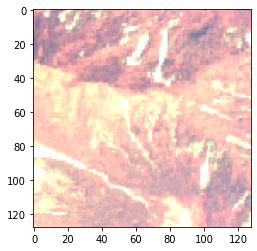

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image[:,:,[4,3,1]])

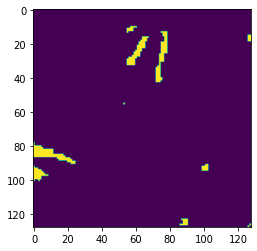

In [ ]:
plt.imshow(label)